# <span style='background:Yellow'> Bottom Temp & Salt difference between SOSE and WOA

In [1]:
from dask_gateway import Gateway
g = Gateway()
cluster = g.connect(g.list_clusters()[0].name)
client = cluster.get_client()

/srv/conda/envs/notebook/lib/python3.9/site-packages/dask_gateway/client.py:21: FutureWarning: format_bytes is deprecated and will be removed in a future release. Please use dask.utils.format_bytes instead.
  from distributed.utils import LoopRunner, format_bytes


In [2]:
client

Connection method: Cluster object,Cluster type: dask_gateway.GatewayCluster
Dashboard: /services/dask-gateway/clusters/prod.e7d7325618484fe6934a49d1a05ade9e/status,


In [3]:
import xarray as xr
from matplotlib import pyplot as plt
import gcsfs
import dask
import dask.array as dsa
import numpy as np
import intake
%matplotlib inline
import cartopy.crs as ccrs #cartopy coord ref sys
import cartopy
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import geopandas
import scipy
import xesmf as xe

In [4]:
woa8110_pt = xr.open_dataset('/home/jovyan/WMT-project/WOA/pt_bottom_wg_8110.nc')
woa8110_slt = xr.open_dataset('/home/jovyan/WMT-project/WOA/san_bottom_wg_8110.nc')

woa8110_pt_error = xr.open_dataset('/home/jovyan/WMT-project/WOA/pt_bottom_error.nc')
woa8110_slt_error = xr.open_dataset('/home/jovyan/WMT-project/WOA/san_bottom_error.nc')

woa0517_pt = xr.open_dataset('/home/jovyan/WMT-project/WOA/pt_bottom_wg_0517.nc')
woa0517_slt = xr.open_dataset('/home/jovyan/WMT-project/WOA/san_bottom_wg_0517.nc')

sose_temp = xr.open_dataset('/home/jovyan/WMT-project/SOSE-budgets/bottom_temp.nc')
sose_slt = xr.open_dataset('/home/jovyan/WMT-project/SOSE-budgets/bottom_slt.nc')

surface_mask_sose = xr.open_dataset('/home/jovyan/WMT-project/SOSE-budgets/surface_mask.nc')

/srv/conda/envs/notebook/lib/python3.9/site-packages/xarray/coding/times.py:195: CFWarning: this date/calendar/year zero convention is not supported by CF
  cftime.num2date(num_dates, units, calendar, only_use_cftime_datetimes=True)
/srv/conda/envs/notebook/lib/python3.9/site-packages/xarray/coding/times.py:673: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/srv/conda/envs/notebook/lib/python3.9/site-packages/xarray/core/indexing.py:423: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)


# <span style='background:Pink'> <font color='Red'> Temperature </font>

### <span style='color:Brown'> Interpolating WOA (1981-2010) temp data onto SOSE's finer grid

In [5]:
regridder = xe.Regridder(woa8110_pt, sose_temp.THETA, method='bilinear')
regridder

/srv/conda/envs/notebook/lib/python3.9/site-packages/xarray/core/dataarray.py:779: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return key in self.data


xESMF Regridder 
Regridding algorithm:       bilinear 
Weight filename:            bilinear_19x96_95x570.nc 
Reuse pre-computed weights? False 
Input grid shape:           (19, 96) 
Output grid shape:          (95, 570) 
Periodic in longitude?      False

In [6]:
woa8110_pt_new_grid = regridder(woa8110_pt)
woa8110_pt_new_grid

<xarray.Dataset>
Dimensions:  (time: 1, YC: 95, XC: 570)
Coordinates:
  * time     (time) datetime64[ns] 2000-01-15
    lon      (XC) float32 295.1 295.2 295.4 295.6 ... 29.42 29.58 29.75 29.92
    lat      (YC) float32 -77.87 -77.71 -77.54 -77.37 ... -62.54 -62.37 -62.21
Dimensions without coordinates: YC, XC
Data variables:
    PT       (time, YC, XC) float64 0.0 0.0 0.0 nan ... -0.6926 -0.6907 -0.6888
Attributes:
    regrid_method:  bilinear

### <span style='color:Brown'> Interpolating WOA (1981-2010) temp error data onto SOSE's grid

In [7]:
regridder_8110_error = xe.Regridder(woa8110_pt_error, sose_temp, method='bilinear')

woa8110_pt_error_new_grid = regridder(woa8110_pt_error)
woa8110_pt_error_new_grid

<xarray.Dataset>
Dimensions:   (time: 1, YC: 95, XC: 570)
Coordinates:
  * time      (time) object -001-01-15 00:00:00
    lon       (XC) float32 295.1 295.2 295.4 295.6 ... 29.42 29.58 29.75 29.92
    lat       (YC) float32 -77.87 -77.71 -77.54 -77.37 ... -62.54 -62.37 -62.21
Dimensions without coordinates: YC, XC
Data variables:
    PT_error  (time, YC, XC) float64 0.0 0.0 0.0 nan ... 0.3323 0.3196 0.3068
Attributes:
    regrid_method:  bilinear

## <span style='background:Yellow'> <font color='Red'> Bottom temperature `SOSE - WOA` (1981-2010) </font>

In [8]:
sose_woa8110_diff = sose_temp.THETA - woa8110_pt_new_grid.isel(time=0).PT
sose_woa8110_diff

<xarray.DataArray (YC: 95, XC: 570)>
array([[0.        , 0.        , 0.        , ...,        nan,        nan,
               nan],
       [0.        , 0.        , 0.        , ...,        nan,        nan,
               nan],
       [0.        , 0.        , 0.        , ...,        nan,        nan,
               nan],
       ...,
       [0.59500206, 0.59372324, 0.58602089, ..., 0.13827111, 0.1367764 ,
        0.1352197 ],
       [0.71324372, 0.71202612, 0.7027545 , ..., 0.12470889, 0.12285769,
        0.12160721],
       [0.8445248 , 0.83526862, 0.81865788, ..., 0.11415889, 0.11163954,
        0.11010068]])
Coordinates:
  * YC       (YC) float64 -77.87 -77.71 -77.54 -77.37 ... -62.54 -62.37 -62.21
  * XC       (XC) float64 295.1 295.2 295.4 295.6 ... 29.42 29.58 29.75 29.92
    Z        (YC, XC) float32 ...
    lat      (YC) float32 -77.87 -77.71 -77.54 -77.37 ... -62.54 -62.37 -62.21
    lon      (XC) float32 295.1 295.2 295.4 295.6 ... 29.42 29.58 29.75 29.92
    time     datetime64[ns] 2000-01-15

/srv/conda/envs/notebook/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/srv/conda/envs/notebook/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


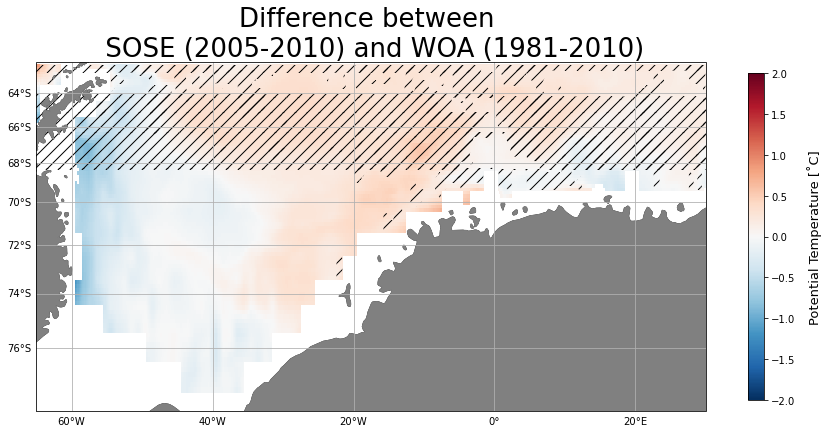

In [12]:
proj = ccrs.Mercator() #with Mercator you can put lat lon values.
fig, ax = plt.subplots(figsize=(15, 15), subplot_kw=dict(projection=proj))

ax.set_extent([-65, 30, -78, -62], crs=ccrs.PlateCarree())
ax.coastlines(resolution='50m')
#ax.add_feature(cfeature.LAND, facecolor='0.8', edgecolor='k')

ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='face',
                                        facecolor='0.5'))

im = ax.pcolormesh(sose_woa8110_diff.lon, 
                   sose_woa8110_diff.lat, 
                   sose_woa8110_diff.where(surface_mask_sose.hFacC), 
                   transform=ccrs.PlateCarree(), cmap='RdBu_r', vmin=-2, vmax=2)
cb = fig.colorbar(im, ax=ax, shrink=0.4)
cb.set_label("Potential Temperature [˚C]", labelpad=12, fontsize=13)

plt.contourf(sose_woa8110_diff.lon, 
             sose_woa8110_diff.lat,  
             sose_woa8110_diff.where(np.abs(sose_woa8110_diff) < woa8110_pt_error_new_grid.PT_error[0]).where(surface_mask_sose.hFacC),
             transform=ccrs.PlateCarree(), colors='none', hatches=['//'])

g1 = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
g1.xlabels_top = False
g1.ylabels_right = False

#ax.text(-0.07, 0.55, 'Latitude', va='bottom', ha='center',
#        rotation='vertical', rotation_mode='anchor',
#        transform=ax.transAxes, fontsize=12)
#ax.text(0.5, -0.13, 'Longitude', va='bottom', ha='center',
#        rotation='horizontal', rotation_mode='anchor',
#        transform=ax.transAxes, fontsize=12)

plt.title("Difference between \n SOSE (2005-2010) and WOA (1981-2010)", fontsize=26)
plt.savefig('bot-temp-soseWoa8110.pdf');

### <span style='color:Brown'> Interpolating WOA (2005-2017) temp data onto SOSE's finer grid

In [ ]:
regridder_2 = xe.Regridder(woa0517_pt, sose_temp, method='bilinear')
regridder_2

In [ ]:
woa0517_pt_new_grid = regridder_2(woa0517_pt)
woa0517_pt_new_grid

In [ ]:
proj = ccrs.Mercator() #with Mercator you can put lat lon values.
fig, ax = plt.subplots(figsize=(15, 15), subplot_kw=dict(projection=proj))

ax.set_extent([-65, 30, -78, -62], crs=ccrs.PlateCarree())
ax.coastlines(resolution='50m')
#ax.add_feature(cfeature.LAND, facecolor='0.8', edgecolor='k')

ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='face',
                                        facecolor='0.5'))

im = ax.pcolormesh(woa0517_pt_new_grid.lon, 
                   woa0517_pt_new_grid.lat, 
                   woa0517_pt_new_grid.PT[0].where(surface_mask_sose.hFacC), transform=ccrs.PlateCarree(), cmap='RdBu_r', vmax=2)
cb = fig.colorbar(im, ax=ax, shrink=0.4)
cb.set_label("Potential Temperature [˚C]", labelpad=12, fontsize=13)

g1 = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
g1.xlabels_top = False
g1.ylabels_right = False

ax.text(-0.07, 0.55, 'Latitude', va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor',
        transform=ax.transAxes, fontsize=12)
ax.text(0.5, -0.13, 'Longitude', va='bottom', ha='center',
        rotation='horizontal', rotation_mode='anchor',
        transform=ax.transAxes, fontsize=12)

plt.title("Bottom temperature from WOA (2005-2017) data \n interpolated onto SOSE's grid", fontsize=14);

## <span style='background:Yellow'> <font color='Red'> Bottom temperature `SOSE - WOA` (2005-2017) </font>

In [ ]:
sose_woa0517_diff = sose_temp.THETA - woa0517_pt_new_grid.isel(time=0).PT
sose_woa0517_diff

In [ ]:
proj = ccrs.Mercator() #with Mercator you can put lat lon values.
fig, ax = plt.subplots(figsize=(15, 15), subplot_kw=dict(projection=proj))

ax.set_extent([-65, 30, -78, -62], crs=ccrs.PlateCarree())
ax.coastlines(resolution='50m')
#ax.add_feature(cfeature.LAND, facecolor='0.8', edgecolor='k')

ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='face',
                                        facecolor='0.5'))

im = ax.pcolormesh(sose_woa0517_diff.lon, 
                   sose_woa0517_diff.lat, 
                   sose_woa0517_diff.where(surface_mask_sose.hFacC), 
                   transform=ccrs.PlateCarree(), cmap='Spectral', vmax=2)
cb = fig.colorbar(im, ax=ax, shrink=0.4)
cb.set_label("Potential Temperature [˚C]", labelpad=12, fontsize=13)

g1 = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
g1.xlabels_top = False
g1.ylabels_right = False

ax.text(-0.07, 0.55, 'Latitude', va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor',
        transform=ax.transAxes, fontsize=12)
ax.text(0.5, -0.13, 'Longitude', va='bottom', ha='center',
        rotation='horizontal', rotation_mode='anchor',
        transform=ax.transAxes, fontsize=12)

plt.title("Difference between \n SOSE (2005-2010) and WOA (2005-2017)", fontsize=14);

# <span style='background:Pink'> <font color='Red'> Salinity </font>

### <span style='color:Brown'> Interpolating WOA (1981-2010) salt data onto SOSE's grid

In [13]:
regridder_slt = xe.Regridder(woa8110_slt, sose_slt, method='bilinear')

woa8110_slt_new_grid = regridder_slt(woa8110_slt)
woa8110_slt_new_grid

<xarray.Dataset>
Dimensions:  (time: 1, YC: 95, XC: 570)
Coordinates:
  * time     (time) datetime64[ns] 2000-01-15
    lon      (XC) float32 295.1 295.2 295.4 295.6 ... 29.42 29.58 29.75 29.92
    lat      (YC) float32 -77.87 -77.71 -77.54 -77.37 ... -62.54 -62.37 -62.21
Dimensions without coordinates: YC, XC
Data variables:
    san      (time, YC, XC) float32 0.0 0.0 0.0 nan ... 34.65 34.65 34.65 34.65
Attributes:
    regrid_method:  bilinear

### <span style='color:Brown'> Interpolating WOA (1981-2010) salt ERROR data onto SOSE's grid

In [14]:
regridder_slt_error = xe.Regridder(woa8110_slt_error.sse.fillna(0.), sose_slt, method='bilinear')

woa8110_slt_error_new_grid = regridder_slt_error(woa8110_slt_error)
woa8110_slt_error_new_grid

/srv/conda/envs/notebook/lib/python3.9/site-packages/xarray/core/dataarray.py:779: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return key in self.data


<xarray.Dataset>
Dimensions:  (time: 1, YC: 95, XC: 570)
Coordinates:
  * time     (time) object -001-01-15 00:00:00
    lon      (XC) float32 295.1 295.2 295.4 295.6 ... 29.42 29.58 29.75 29.92
    lat      (YC) float32 -77.87 -77.71 -77.54 -77.37 ... -62.54 -62.37 -62.21
Dimensions without coordinates: YC, XC
Data variables:
    sse      (time, YC, XC) float32 0.0 0.0 0.0 ... 0.0003343 0.0003656
Attributes:
    regrid_method:  bilinear

## <span style='background:Yellow'> <font color='Red'> Bottom salinity `SOSE - WOA` (1981-2010) </font>

In [15]:
#checking if nans
print(np.isnan(sose_slt.SALT.sum()))

<xarray.DataArray 'SALT' ()>
array(False)


In [16]:
sose_woa8110_slt_diff = sose_slt.SALT - woa8110_slt_new_grid.isel(time=0).san
sose_woa8110_slt_diff

<xarray.DataArray (YC: 95, XC: 570)>
array([[ 0.        ,  0.        ,  0.        , ...,         nan,
                nan,         nan],
       [ 0.        ,  0.        ,  0.        , ...,         nan,
                nan,         nan],
       [ 0.        ,  0.        ,  0.        , ...,         nan,
                nan,         nan],
       ...,
       [33.708538  , 33.709415  , 33.709522  , ..., -0.79683304,
        -0.79504395, -0.79348373],
       [33.72277   , 33.723537  , 33.72321   , ..., -0.7939377 ,
        -0.79288864, -0.79192734],
       [33.741817  , 33.74131   , 33.739555  , ..., -0.7909241 ,
        -0.790699  , -0.7902489 ]], dtype=float32)
Coordinates:
  * YC       (YC) float64 -77.87 -77.71 -77.54 -77.37 ... -62.54 -62.37 -62.21
  * XC       (XC) float64 295.1 295.2 295.4 295.6 ... 29.42 29.58 29.75 29.92
    Z        (YC, XC) float32 ...
    lat      (YC) float32 -77.87 -77.71 -77.54 -77.37 ... -62.54 -62.37 -62.21
    lon      (XC) float32 295.1 295.2 295.4 295.6 ... 29.42 29.58 29.75 29.92
    time     datetime64[ns] 2000-01-15

/srv/conda/envs/notebook/lib/python3.9/site-packages/matplotlib/contour.py:1486: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
/srv/conda/envs/notebook/lib/python3.9/site-packages/matplotlib/contour.py:1487: UserWarning: Warning: converting a masked element to nan.
  self.zmin = float(z.min())
/srv/conda/envs/notebook/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/srv/conda/envs/notebook/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


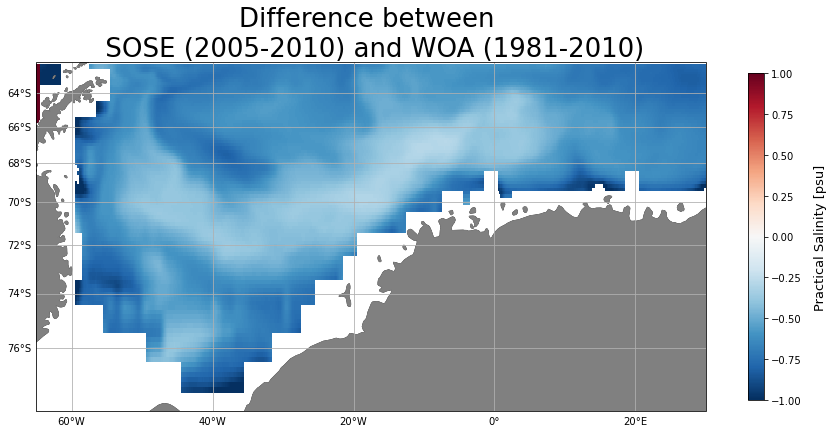

In [18]:
proj = ccrs.Mercator() #with Mercator you can put lat lon values.
fig, ax = plt.subplots(figsize=(15, 15), subplot_kw=dict(projection=proj))

ax.set_extent([-65, 30, -78, -62], crs=ccrs.PlateCarree())
ax.coastlines(resolution='50m')
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                            edgecolor='face',
                                            facecolor='0.5'))
im = ax.pcolormesh(sose_woa8110_slt_diff.lon, 
                   sose_woa8110_slt_diff.lat, 
                   sose_woa8110_slt_diff.where(surface_mask_sose.hFacC),
                   transform=ccrs.PlateCarree(), cmap='RdBu_r', vmin=-1, vmax=1)
cb = fig.colorbar(im, ax=ax, shrink=0.4)
cb.set_label("Practical Salinity [psu]", labelpad=12, fontsize=13)

plt.contourf(sose_woa8110_slt_diff.lon, 
             sose_woa8110_slt_diff.lat, 
             sose_woa8110_slt_diff.where(np.abs(sose_woa8110_slt_diff) < woa8110_slt_error_new_grid.sse[0]).where(surface_mask_sose.hFacC),
             transform=ccrs.PlateCarree(), colors='none', hatches=['/'])

g1 = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
g1.xlabels_top = False
g1.ylabels_right = False

#ax.text(-0.07, 0.55, 'Latitude', va='bottom', ha='center',
#        rotation='vertical', rotation_mode='anchor',
#        transform=ax.transAxes, fontsize=12)
#ax.text(0.5, -0.13, 'Longitude', va='bottom', ha='center',
#        rotation='horizontal', rotation_mode='anchor',
#        transform=ax.transAxes, fontsize=12)

plt.title("Difference between \n SOSE (2005-2010) and WOA (1981-2010)", fontsize=26)
plt.savefig('bot-salt-soseWoa8110.pdf');

### <span style='color:Brown'> Interpolating WOA (2005-2017) salt data onto SOSE's grid

In [ ]:
regridder_2_slt = xe.Regridder(woa0517_slt, sose_slt, method='bilinear')
regridder_2_slt

In [ ]:
woa0517_slt_new_grid = regridder_2_slt(woa0517_slt)
woa0517_slt_new_grid

In [ ]:
proj = ccrs.Mercator() #with Mercator you can put lat lon values.
fig, ax = plt.subplots(figsize=(15, 15), subplot_kw=dict(projection=proj))

ax.set_extent([-65, 30, -78, -62], crs=ccrs.PlateCarree())
ax.coastlines(resolution='50m')
#ax.add_feature(cfeature.LAND, facecolor='0.8', edgecolor='k')

ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='face',
                                        facecolor='0.5'))

im = ax.pcolormesh(woa0517_slt_new_grid.lon, 
                   woa0517_slt_new_grid.lat, 
                   woa0517_slt_new_grid.san[0].where(surface_mask_sose.hFacC), 
                   transform=ccrs.PlateCarree(), cmap='viridis', vmin=32, vmax=35)
cb = fig.colorbar(im, ax=ax, shrink=0.4)
cb.set_label("Potential Temperature [˚C]", labelpad=12, fontsize=13)

g1 = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
g1.xlabels_top = False
g1.ylabels_right = False

ax.text(-0.07, 0.55, 'Latitude', va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor',
        transform=ax.transAxes, fontsize=12)
ax.text(0.5, -0.13, 'Longitude', va='bottom', ha='center',
        rotation='horizontal', rotation_mode='anchor',
        transform=ax.transAxes, fontsize=12)

plt.title("Bottom temperature from WOA (2005-2017) data \n interpolated onto SOSE's grid", fontsize=14);

## <span style='background:Yellow'> <font color='Red'> Bottom salinity `SOSE - WOA` (2005-2017) </font>

In [ ]:
sose_woa0517_slt_diff = sose_slt.SALT - woa0517_slt_new_grid.isel(time=0).san
sose_woa0517_slt_diff

In [ ]:
proj = ccrs.Mercator() #with Mercator you can put lat lon values.
fig, ax = plt.subplots(figsize=(15, 15), subplot_kw=dict(projection=proj))

ax.set_extent([-65, 30, -78, -62], crs=ccrs.PlateCarree())
ax.coastlines(resolution='50m')
#ax.add_feature(cfeature.LAND, facecolor='0.8', edgecolor='k')

ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='face',
                                        facecolor='0.5'))

im = ax.pcolormesh(sose_woa0517_slt_diff.lon, 
                   sose_woa0517_slt_diff.lat, 
                   sose_woa0517_slt_diff.where(surface_mask_sose.hFacC), 
                   transform=ccrs.PlateCarree(), cmap='Spectral', vmin=-1, vmax=0)
cb = fig.colorbar(im, ax=ax, shrink=0.4)
cb.set_label("Practical Salinity [psu]", labelpad=12, fontsize=13)

g1 = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
g1.xlabels_top = False
g1.ylabels_right = False

ax.text(-0.07, 0.55, 'Latitude', va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor',
        transform=ax.transAxes, fontsize=12)
ax.text(0.5, -0.13, 'Longitude', va='bottom', ha='center',
        rotation='horizontal', rotation_mode='anchor',
        transform=ax.transAxes, fontsize=12)

plt.title("Difference between \n SOSE (2005-2010) and WOA (2005-2017)", fontsize=14);